In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader, Batch
from torch_geometric.datasets import MoleculeNet
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import KFold
from rdkit.Chem.Scaffolds import MurckoScaffold
from torch_geometric.loader import DataLoader




<div style="text-align:center;color:Blue">
    <h3> Lipophilicty dataset import (load if already imported) and explore</h3>
</div>

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess dataset
dataset = MoleculeNet(root=".", name="lipo")

# Ensure proper data types
for data in dataset:
    data.x = data.x.float()
    data.y = data.y.float()

In [33]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import KFold

def scaffold_split(dataset, k=5):
    # Step 1: Compute scaffolds for all molecules
    scaffolds = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
        scaffolds.append(scaffold)

    # Step 2: Map each scaffold to all indices with that scaffold
    scaffold_to_indices = {}
    for idx, scaffold in enumerate(scaffolds):
        scaffold_to_indices.setdefault(scaffold, []).append(idx)

    # Step 3: Unique scaffolds for splitting
    unique_scaffolds = list(scaffold_to_indices.keys())
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(unique_scaffolds):
        train_scaffolds = set([unique_scaffolds[i] for i in train_idx])
        test_scaffolds = set([unique_scaffolds[i] for i in test_idx])

        # Step 4: Assign all molecules with a scaffold to the same split
        train_indices = []
        test_indices = []
        for scaffold, indices in scaffold_to_indices.items():
            if scaffold in train_scaffolds:
                train_indices.extend(indices)
            else:
                test_indices.extend(indices)

        train_dataset = dataset[train_indices]
        test_dataset = dataset[test_indices]

        yield train_dataset, test_dataset


In [34]:
# Get split datasets
train_dataset, test_dataset = next(scaffold_split(dataset))

In [35]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_scaffolds(dataset):
    scaffolds = set()
    for data in dataset:
        # If your data object has a 'smiles' attribute
        mol = Chem.MolFromSmiles(data.smiles)
        scaffold_smiles = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
        scaffolds.add(scaffold_smiles)
    return scaffolds


In [36]:
train_scaffolds = get_scaffolds(train_dataset)
test_scaffolds = get_scaffolds(test_dataset)
overlap = train_scaffolds & test_scaffolds
print(f"Number of overlapping scaffolds: {len(overlap)}")


Number of overlapping scaffolds: 0


In [37]:
print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 3453
Test set size: 747


In [72]:
# Model definition
class ImprovedGCN(nn.Module):
    def __init__(self, num_features):
        super(ImprovedGCN, self).__init__()
        
        self.conv1 = GCNConv(num_features, 128)
        self.bn1 = BatchNorm(128)
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = GCNConv(128, 256)
        self.bn2 = BatchNorm(256)
        self.drop2 = nn.Dropout(0.3)
        
        self.conv3 = GCNConv(256, 512)
        self.bn3 = BatchNorm(512)
        self.drop3 = nn.Dropout(0.3)
        
        self.conv4 = GCNConv(512, 256)
        self.bn4 = BatchNorm(256)
        
        self.lin1 = nn.Linear(512, 128)
        self.lin2 = nn.Linear(128, 1)
        
    def forward(self, x, edge_index, batch_index):
        x = x.float()
        edge_index = edge_index.long()
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.drop1(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.drop2(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.drop3(x)
        
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        
        x1 = gmp(x, batch_index)
        x2 = gap(x, batch_index)
        x = torch.cat([x1, x2], dim=1)
        
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)
        
        return x, x

# Initialize model

num_features = dataset[0].x.shape[1]
improvedgcn_model = ImprovedGCN(num_features).to(device)

import pandas as pd

# Collect model parameter names and shapes
params = [(name, tuple(param.shape)) for name, param in improvedgcn_model.named_parameters()]

# Create a DataFrame for better visualization
params_df = pd.DataFrame(params, columns=['Parameter Name', 'Shape'])

# Print the DataFrame as a table
print(params_df)




       Parameter Name       Shape
0          conv1.bias      (128,)
1    conv1.lin.weight    (128, 9)
2   bn1.module.weight      (128,)
3     bn1.module.bias      (128,)
4          conv2.bias      (256,)
5    conv2.lin.weight  (256, 128)
6   bn2.module.weight      (256,)
7     bn2.module.bias      (256,)
8          conv3.bias      (512,)
9    conv3.lin.weight  (512, 256)
10  bn3.module.weight      (512,)
11    bn3.module.bias      (512,)
12         conv4.bias      (256,)
13   conv4.lin.weight  (256, 512)
14  bn4.module.weight      (256,)
15    bn4.module.bias      (256,)
16        lin1.weight  (128, 512)
17          lin1.bias      (128,)
18        lin2.weight    (1, 128)
19          lin2.bias        (1,)


In [73]:
from torch_geometric.loader import DataLoader

# Data loaders with collate function
def collate_fn(batch):
    batch = Batch.from_data_list(batch)
    batch.x = batch.x.float()
    batch.y = batch.y.float()
    return batch

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Training setup
optimizer = AdamW(improvedgcn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
loss_fn = nn.MSELoss()


In [74]:
# Training and evaluation functions
def train(improvedgcn_model, loader):
    improvedgcn_model.train()
    total_loss = 0
    preds, targets = [], []
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred, _ = improvedgcn_model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
        preds.append(pred.detach().cpu().numpy())
        targets.append(batch.y.detach().cpu().numpy())
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    
    return total_loss / len(loader.dataset), r2, mae, rmse

In [75]:
def test(improvedgcn_model, loader):
    improvedgcn_model.eval()
    total_loss = 0
    preds, targets = [], []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = improvedgcn_model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y)
            
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.detach().cpu().numpy())
            targets.append(batch.y.detach().cpu().numpy())
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    
    return total_loss / len(loader.dataset), r2, mae, rmse

In [76]:
# Training loop
best_val_r2 = -np.inf
train_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}
val_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}

for epoch in range(1, 1001):
    train_loss, train_r2, train_mae, train_rmse = train(improvedgcn_model, train_loader)
    val_loss, val_r2, val_mae, val_rmse = test(improvedgcn_model, test_loader)
    
    scheduler.step(val_loss)
    
    # Save history
    train_history['loss'].append(train_loss)
    train_history['r2'].append(train_r2)
    train_history['mae'].append(train_mae)
    train_history['rmse'].append(train_rmse)
    
    val_history['loss'].append(val_loss)
    val_history['r2'].append(val_r2)
    val_history['mae'].append(val_mae)
    val_history['rmse'].append(val_rmse)
    
    # Early stopping
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(improvedgcn_model.state_dict(), 'best_improvedgcn_model_weights.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 100:
            print(f'Early stopping at epoch {epoch}')
            break
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}:')
        print(f'Train Loss: {train_loss:.4f} | R2: {train_r2:.4f} | MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f}')
        print(f'Val Loss: {val_loss:.4f} | R2: {val_r2:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}\n')
# Load best model
improvedgcn_model.load_state_dict(torch.load('best_improvedgcn_model_weights.pt'))

# Evaluate on test set
test_loss, test_r2, test_mae, test_rmse = test(improvedgcn_model, test_loader)
# Get predictions and targets for accuracy
improvedgcn_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred, _ = improvedgcn_model(batch.x, batch.edge_index, batch.batch)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())
all_preds = np.concatenate(all_preds).reshape(-1)
all_targets = np.concatenate(all_targets).reshape(-1)


print("=== Final Test Set Performance ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



Epoch 050:
Train Loss: 0.4083 | R2: 0.7237 | MAE: 0.4960 | RMSE: 0.6390
Val Loss: 0.8133 | R2: 0.3762 | MAE: 0.7172 | RMSE: 0.9018

Epoch 100:
Train Loss: 0.2646 | R2: 0.8209 | MAE: 0.4046 | RMSE: 0.5144
Val Loss: 0.5906 | R2: 0.5470 | MAE: 0.5857 | RMSE: 0.7685

Epoch 150:
Train Loss: 0.1940 | R2: 0.8687 | MAE: 0.3452 | RMSE: 0.4404
Val Loss: 0.6073 | R2: 0.5343 | MAE: 0.5785 | RMSE: 0.7793

Epoch 200:
Train Loss: 0.1279 | R2: 0.9134 | MAE: 0.2809 | RMSE: 0.3576
Val Loss: 0.5692 | R2: 0.5634 | MAE: 0.5546 | RMSE: 0.7545

Early stopping at epoch 229


/var/folders/2v/vxp2bq6n3wq9lw0n54pp30_00000gn/T/ipykernel_2311/1965810366.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  improvedgcn_model.load_state_dict(torch.load(

=== Final Test Set Performance ===
Test Loss: 0.5402
Test R2: 0.5857
Test MAE: 0.5411
Test RMSE: 0.7350


## using more models

### GIN model

In [45]:
from torch_geometric.nn import GINConv

class GINNet(nn.Module):
    def __init__(self, num_features):
        super(GINNet, self).__init__()
        nn1 = nn.Sequential(nn.Linear(num_features, 128), nn.ReLU(), nn.Linear(128, 128))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm(128)
        self.drop1 = nn.Dropout(0.3)
        nn2 = nn.Sequential(nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 256))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm(256)
        self.drop2 = nn.Dropout(0.3)
        nn3 = nn.Sequential(nn.Linear(256, 512), nn.ReLU(), nn.Linear(512, 512))
        self.conv3 = GINConv(nn3)
        self.bn3 = BatchNorm(512)
        self.drop3 = nn.Dropout(0.3)
        nn4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 256))
        self.conv4 = GINConv(nn4)
        self.bn4 = BatchNorm(256)
        self.lin1 = nn.Linear(512, 128)
        self.lin2 = nn.Linear(128, 1)
    def forward(self, x, edge_index, batch_index):
        x = x.float()
        edge_index = edge_index.long()
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.drop1(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.drop2(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.drop3(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x1 = gmp(x, batch_index)
        x2 = gap(x, batch_index)
        x = torch.cat([x1, x2], dim=1)
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)
        return x, x
    
# Initialize model

num_features = dataset[0].x.shape[1]
gin_model = GINNet(num_features).to(device)

import pandas as pd

# Collect model parameter names and shapes
params = [(name, tuple(param.shape)) for name, param in gin_model.named_parameters()]

# Create a DataFrame for better visualization
params_df = pd.DataFrame(params, columns=['Parameter Name', 'Shape'])

# Print the DataFrame as a table
print(params_df)


       Parameter Name       Shape
0   conv1.nn.0.weight    (128, 9)
1     conv1.nn.0.bias      (128,)
2   conv1.nn.2.weight  (128, 128)
3     conv1.nn.2.bias      (128,)
4   bn1.module.weight      (128,)
5     bn1.module.bias      (128,)
6   conv2.nn.0.weight  (256, 128)
7     conv2.nn.0.bias      (256,)
8   conv2.nn.2.weight  (256, 256)
9     conv2.nn.2.bias      (256,)
10  bn2.module.weight      (256,)
11    bn2.module.bias      (256,)
12  conv3.nn.0.weight  (512, 256)
13    conv3.nn.0.bias      (512,)
14  conv3.nn.2.weight  (512, 512)
15    conv3.nn.2.bias      (512,)
16  bn3.module.weight      (512,)
17    bn3.module.bias      (512,)
18  conv4.nn.0.weight  (256, 512)
19    conv4.nn.0.bias      (256,)
20  conv4.nn.2.weight  (256, 256)
21    conv4.nn.2.bias      (256,)
22  bn4.module.weight      (256,)
23    bn4.module.bias      (256,)
24        lin1.weight  (128, 512)
25          lin1.bias      (128,)
26        lin2.weight    (1, 128)
27          lin2.bias        (1,)


In [53]:
# Training setup
gin_optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
gin_loss_fn = nn.MSELoss()

In [54]:
def gin_train(gin_model, loader):
    gin_model.train()
    total_loss = 0
    preds, targets = [], []
    
    for batch in loader:
        batch = batch.to(device)
        gin_optimizer.zero_grad()
        pred, _ = gin_model(batch.x, batch.edge_index, batch.batch)
        loss = gin_loss_fn(pred, batch.y)
        loss.backward()
        gin_optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
        preds.append(pred.detach().cpu().numpy())
        targets.append(batch.y.detach().cpu().numpy())
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    
    return total_loss / len(loader.dataset), r2, mae, rmse

In [56]:
def gin_test(gin_model, loader):
    gin_model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = gin_model(batch.x, batch.edge_index, batch.batch)
            loss = gin_loss_fn(pred, batch.y)
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.detach().cpu().numpy())
            targets.append(batch.y.detach().cpu().numpy())
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    return total_loss / len(loader.dataset), r2, mae, rmse

In [58]:
best_val_r2 = -np.inf
epochs_no_improve = 0
gin_train_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}
gin_val_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}

for epoch in range(1, 1001):
    train_loss, train_r2, train_mae, train_rmse = gin_train(gin_model, train_loader)
    val_loss, val_r2, val_mae, val_rmse = gin_test(gin_model, test_loader)
    
    # Save history
    gin_train_history['loss'].append(train_loss)
    gin_train_history['r2'].append(train_r2)
    gin_train_history['mae'].append(train_mae)
    gin_train_history['rmse'].append(train_rmse)
    gin_val_history['loss'].append(val_loss)
    gin_val_history['r2'].append(val_r2)
    gin_val_history['mae'].append(val_mae)
    gin_val_history['rmse'].append(val_rmse)
    
    # Early stopping
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(gin_model.state_dict(), 'best_gin_model_weights.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 100:
            print(f'Early stopping at epoch {epoch}')
            break
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}:')
        print(f'Train Loss: {train_loss:.4f} | R2: {train_r2:.4f} | MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f}')
        print(f'Val Loss: {val_loss:.4f} | R2: {val_r2:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}\n')
        
gin_model.load_state_dict(torch.load('best_gin_model_weights.pt'))
gin_model.eval()

test_loss, test_r2, test_mae, test_rmse = gin_test(gin_model, test_loader)
print("=== Final Test Set Performance (GIN) ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



Epoch 050:
Train Loss: 0.3923 | R2: 0.7345 | MAE: 0.4867 | RMSE: 0.6264
Val Loss: 0.6028 | R2: 0.5377 | MAE: 0.5955 | RMSE: 0.7764

Epoch 100:
Train Loss: 0.1919 | R2: 0.8701 | MAE: 0.3418 | RMSE: 0.4381
Val Loss: 0.4932 | R2: 0.6217 | MAE: 0.5276 | RMSE: 0.7023

Epoch 150:
Train Loss: 0.1097 | R2: 0.9258 | MAE: 0.2592 | RMSE: 0.3312
Val Loss: 0.5113 | R2: 0.6079 | MAE: 0.5335 | RMSE: 0.7150

Early stopping at epoch 190
=== Final Test Set Performance (GIN) ===
Test Loss: 0.4177
Test R2: 0.6797
Test MAE: 0.4908
Test RMSE: 0.6463


/var/folders/2v/vxp2bq6n3wq9lw0n54pp30_00000gn/T/ipykernel_2311/3175730444.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gin_model.load_state_dict(torch.load('best_gi

### GraphSAGE Model

In [46]:
from torch_geometric.nn import SAGEConv

class GraphSAGENet(nn.Module):
    def __init__(self, num_features):
        super(GraphSAGENet, self).__init__()
        self.conv1 = SAGEConv(num_features, 128)
        self.bn1 = BatchNorm(128)
        self.drop1 = nn.Dropout(0.3)
        self.conv2 = SAGEConv(128, 256)
        self.bn2 = BatchNorm(256)
        self.drop2 = nn.Dropout(0.3)
        self.conv3 = SAGEConv(256, 512)
        self.bn3 = BatchNorm(512)
        self.drop3 = nn.Dropout(0.3)
        self.conv4 = SAGEConv(512, 256)
        self.bn4 = BatchNorm(256)
        self.lin1 = nn.Linear(512, 128)
        self.lin2 = nn.Linear(128, 1)
    def forward(self, x, edge_index, batch_index):
        x = x.float()
        edge_index = edge_index.long()
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.drop1(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.drop2(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.drop3(x)
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x1 = gmp(x, batch_index)
        x2 = gap(x, batch_index)
        x = torch.cat([x1, x2], dim=1)
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)
        return x, x
    
# Initialize model

num_features = dataset[0].x.shape[1]
gsn_model = GraphSAGENet(num_features).to(device)

import pandas as pd

# Collect model parameter names and shapes
params = [(name, tuple(param.shape)) for name, param in gsn_model.named_parameters()]

# Create a DataFrame for better visualization
params_df = pd.DataFrame(params, columns=['Parameter Name', 'Shape'])

# Print the DataFrame as a table
print(params_df)


        Parameter Name       Shape
0   conv1.lin_l.weight    (128, 9)
1     conv1.lin_l.bias      (128,)
2   conv1.lin_r.weight    (128, 9)
3    bn1.module.weight      (128,)
4      bn1.module.bias      (128,)
5   conv2.lin_l.weight  (256, 128)
6     conv2.lin_l.bias      (256,)
7   conv2.lin_r.weight  (256, 128)
8    bn2.module.weight      (256,)
9      bn2.module.bias      (256,)
10  conv3.lin_l.weight  (512, 256)
11    conv3.lin_l.bias      (512,)
12  conv3.lin_r.weight  (512, 256)
13   bn3.module.weight      (512,)
14     bn3.module.bias      (512,)
15  conv4.lin_l.weight  (256, 512)
16    conv4.lin_l.bias      (256,)
17  conv4.lin_r.weight  (256, 512)
18   bn4.module.weight      (256,)
19     bn4.module.bias      (256,)
20         lin1.weight  (128, 512)
21           lin1.bias      (128,)
22         lin2.weight    (1, 128)
23           lin2.bias        (1,)


In [59]:
gsn_optimizer = torch.optim.Adam(gsn_model.parameters(), lr=0.001)
gsn_loss_fn = nn.MSELoss()

In [60]:
def gsn_train(gsn_model, loader):
    gsn_model.train()
    total_loss = 0
    preds, targets = [], []
    for batch in loader:
        batch = batch.to(device)
        gsn_optimizer.zero_grad()
        pred, _ = gsn_model(batch.x, batch.edge_index, batch.batch)
        loss = gsn_loss_fn(pred, batch.y)
        loss.backward()
        gsn_optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        preds.append(pred.detach().cpu().numpy())
        targets.append(batch.y.detach().cpu().numpy())
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    return total_loss / len(loader.dataset), r2, mae, rmse

def gsn_test(gsn_model, loader):
    gsn_model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = gsn_model(batch.x, batch.edge_index, batch.batch)
            loss = gsn_loss_fn(pred, batch.y)
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.detach().cpu().numpy())
            targets.append(batch.y.detach().cpu().numpy())
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    return total_loss / len(loader.dataset), r2, mae, rmse


In [61]:
best_val_r2 = -np.inf
epochs_no_improve = 0
gsn_train_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}
gsn_val_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}

for epoch in range(1, 1001):
    train_loss, train_r2, train_mae, train_rmse = gsn_train(gsn_model, train_loader)
    val_loss, val_r2, val_mae, val_rmse = gsn_test(gsn_model, test_loader)
    gsn_train_history['loss'].append(train_loss)
    gsn_train_history['r2'].append(train_r2)
    gsn_train_history['mae'].append(train_mae)
    gsn_train_history['rmse'].append(train_rmse)
    gsn_val_history['loss'].append(val_loss)
    gsn_val_history['r2'].append(val_r2)
    gsn_val_history['mae'].append(val_mae)
    gsn_val_history['rmse'].append(val_rmse)
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(gsn_model.state_dict(), 'best_gsn_model_weights.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 100:
            print(f'Early stopping at epoch {epoch}')
            break
    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}:')
        print(f'Train Loss: {train_loss:.4f} | R2: {train_r2:.4f} | MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f}')
        print(f'Val Loss: {val_loss:.4f} | R2: {val_r2:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}\n')
        
gsn_model.load_state_dict(torch.load('best_gsn_model_weights.pt'))
gsn_model.eval()
test_loss, test_r2, test_mae, test_rmse = gsn_test(gsn_model, test_loader)
print("=== Final Test Set Performance (GSN) ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Epoch 050:
Train Loss: 0.3478 | R2: 0.7646 | MAE: 0.4610 | RMSE: 0.5898
Val Loss: 0.4666 | R2: 0.6421 | MAE: 0.5156 | RMSE: 0.6831

Epoch 100:
Train Loss: 0.2079 | R2: 0.8593 | MAE: 0.3583 | RMSE: 0.4559
Val Loss: 0.4314 | R2: 0.6692 | MAE: 0.5002 | RMSE: 0.6568

Epoch 150:
Train Loss: 0.1392 | R2: 0.9058 | MAE: 0.2923 | RMSE: 0.3731
Val Loss: 0.4174 | R2: 0.6799 | MAE: 0.4818 | RMSE: 0.6460

Epoch 200:
Train Loss: 0.1060 | R2: 0.9283 | MAE: 0.2539 | RMSE: 0.3256
Val Loss: 0.4371 | R2: 0.6647 | MAE: 0.4873 | RMSE: 0.6612

Early stopping at epoch 211
=== Final Test Set Performance (GSN) ===
Test Loss: 0.3773
Test R2: 0.7106
Test MAE: 0.4613
Test RMSE: 0.6142


/var/folders/2v/vxp2bq6n3wq9lw0n54pp30_00000gn/T/ipykernel_2311/1782872378.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gsn_model.load_state_dict(torch.load('best_gs

### Visualisations

In [64]:
def plot_model_results(train_history_gin, val_history_gin, train_history_gsn, val_history_gsn, train_history_improvedgcn, val_history_improvedgcn):
    plt.figure(figsize=(18, 12))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(train_history_gin['loss'])+1), train_history_gin['loss'], label='GIN Train Loss')
    plt.plot(range(1, len(val_history_gin['loss'])+1), val_history_gin['loss'], label='GIN Val Loss')
    plt.plot(range(1, len(train_history_gsn['loss'])+1), train_history_gsn['loss'], label='GSN Train Loss')
    plt.plot(range(1, len(val_history_gsn['loss'])+1), val_history_gsn['loss'], label='GSN Val Loss')
    plt.plot(range(1, len(train_history_improvedgcn['loss'])+1), train_history_improvedgcn['loss'], label='ImprovedGCN Train Loss')
    plt.plot(range(1, len(val_history_improvedgcn['loss'])+1), val_history_improvedgcn['loss'], label='ImprovedGCN Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Repeat for R2, MAE, RMSE (just like above)
    # R2
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(train_history_gin['r2'])+1), train_history_gin['r2'], label='GIN Train R2')
    plt.plot(range(1, len(val_history_gin['r2'])+1), val_history_gin['r2'], label='GIN Val R2')
    plt.plot(range(1, len(train_history_gsn['r2'])+1), train_history_gsn['r2'], label='GSN Train R2')
    plt.plot(range(1, len(val_history_gsn['r2'])+1), val_history_gsn['r2'], label='GSN Val R2')
    plt.plot(range(1, len(train_history_improvedgcn['r2'])+1), train_history_improvedgcn['r2'], label='ImprovedGCN Train R2')
    plt.plot(range(1, len(val_history_improvedgcn['r2'])+1), val_history_improvedgcn['r2'], label='ImprovedGCN Val R2')
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.title('Training and Validation R2 Score')
    plt.legend()

    # MAE
    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(train_history_gin['mae'])+1), train_history_gin['mae'], label='GIN Train MAE')
    plt.plot(range(1, len(val_history_gin['mae'])+1), val_history_gin['mae'], label='GIN Val MAE')
    plt.plot(range(1, len(train_history_gsn['mae'])+1), train_history_gsn['mae'], label='GSN Train MAE')
    plt.plot(range(1, len(val_history_gsn['mae'])+1), val_history_gsn['mae'], label='GSN Val MAE')
    plt.plot(range(1, len(train_history_improvedgcn['mae'])+1), train_history_improvedgcn['mae'], label='ImprovedGCN Train MAE')
    plt.plot(range(1, len(val_history_improvedgcn['mae'])+1), val_history_improvedgcn['mae'], label='ImprovedGCN Val MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()

    # RMSE
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(train_history_gin['rmse'])+1), train_history_gin['rmse'], label='GIN Train RMSE')
    plt.plot(range(1, len(val_history_gin['rmse'])+1), val_history_gin['rmse'], label='GIN Val RMSE')
    plt.plot(range(1, len(train_history_gsn['rmse'])+1), train_history_gsn['rmse'], label='GSN Train RMSE')
    plt.plot(range(1, len(val_history_gsn['rmse'])+1), val_history_gsn['rmse'], label='GSN Val RMSE')
    plt.plot(range(1, len(train_history_improvedgcn['rmse'])+1), train_history_improvedgcn['rmse'], label='ImprovedGCN Train RMSE')
    plt.plot(range(1, len(val_history_improvedgcn['rmse'])+1), val_history_improvedgcn['rmse'], label='ImprovedGCN Val RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Squared Error')
    plt.title('Training and Validation RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()


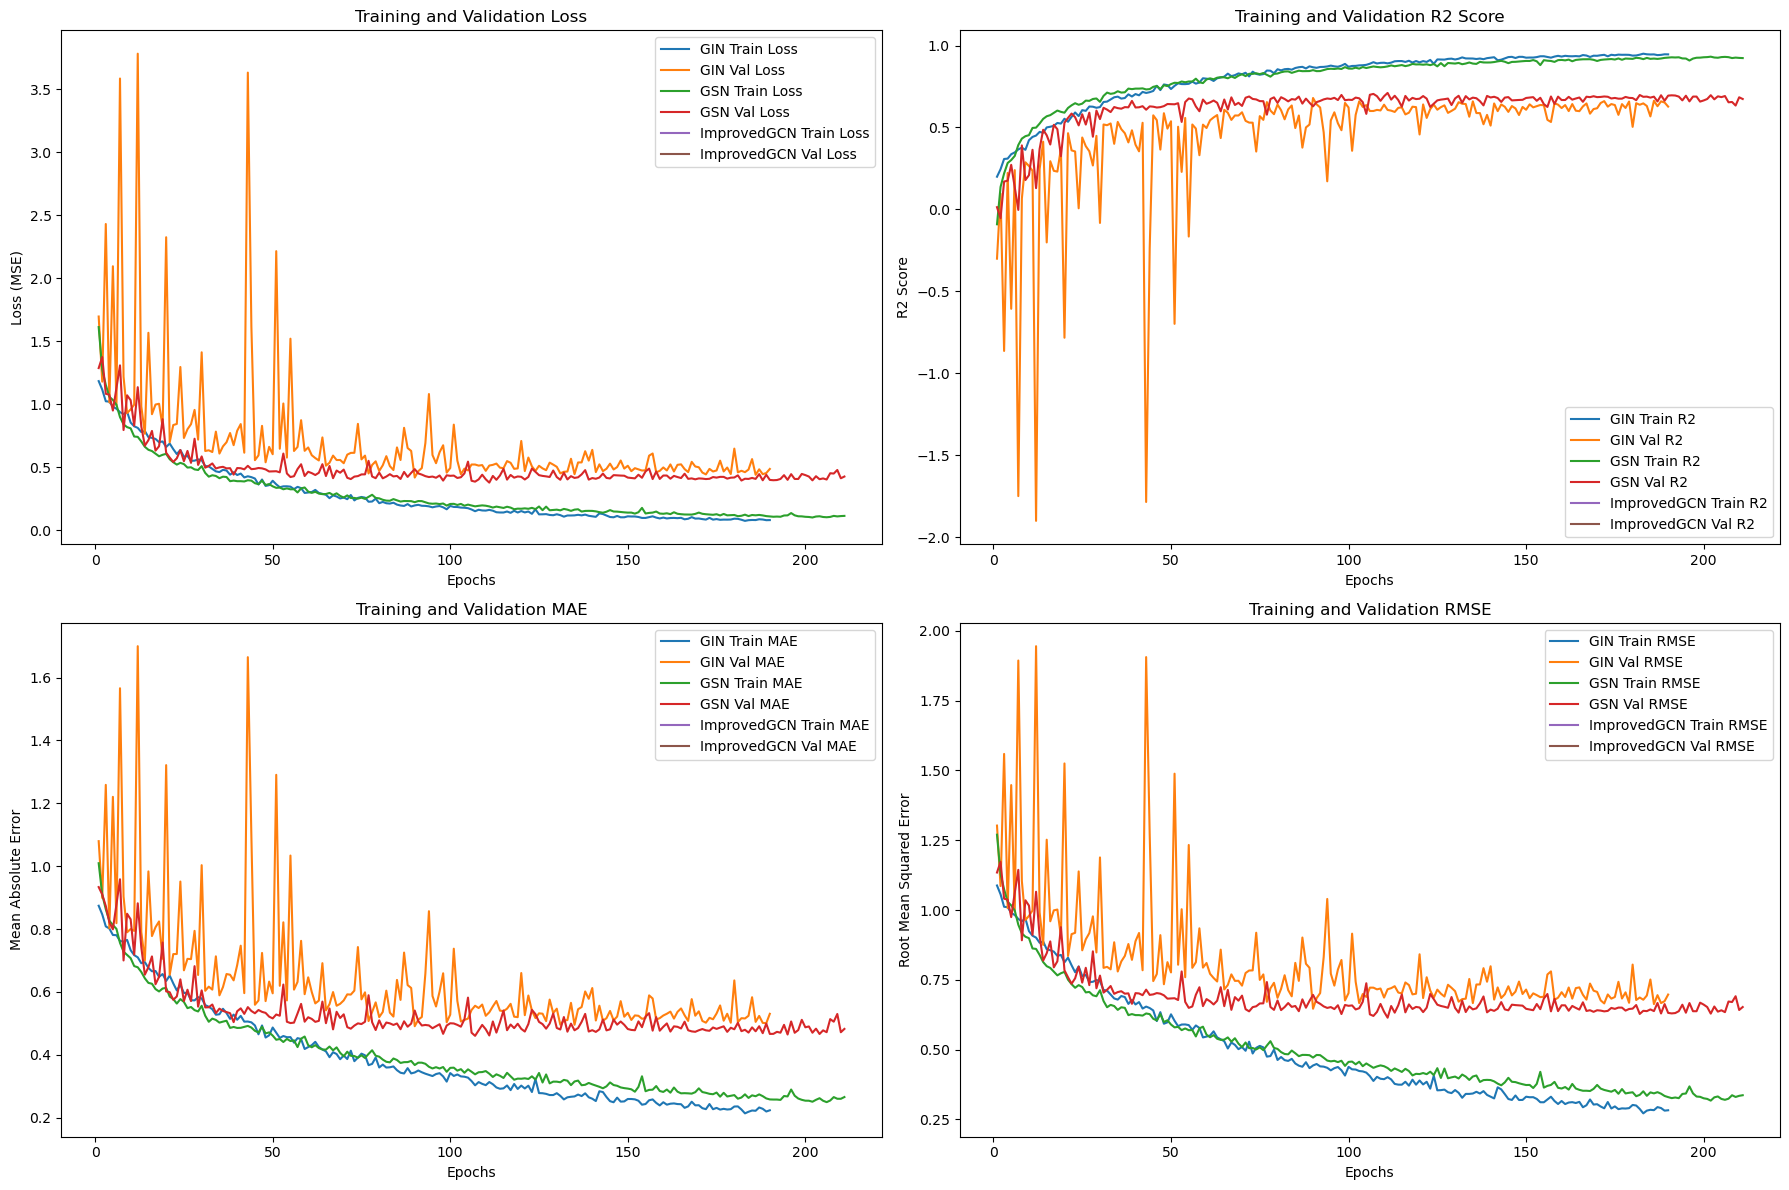

In [65]:
plot_model_results(
    gin_train_history, gin_val_history,
    gsn_train_history, gsn_val_history,
    train_history, val_history
)


## Predictions

In [80]:
# Initialize models
gin_model = GINNet(num_features).to(device)
gsn_model = GraphSAGENet(num_features).to(device)
improvedgcn_model = ImprovedGCN(num_features).to(device)

# Load best weights
gin_model.load_state_dict(torch.load('best_gin_model_weights.pt'))
gsn_model.load_state_dict(torch.load('best_gsn_model_weights.pt'))
improvedgcn_model.load_state_dict(torch.load('best_improvedgcn_model_weights.pt'))


/var/folders/2v/vxp2bq6n3wq9lw0n54pp30_00000gn/T/ipykernel_2311/3939732855.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gin_model.load_state_dict(torch.load('best_gin

<All keys matched successfully>

In [81]:
def get_predictions(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = model(batch.x, batch.edge_index, batch.batch)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())
    all_preds = np.concatenate(all_preds).reshape(-1)
    all_targets = np.concatenate(all_targets).reshape(-1)
    return all_preds, all_targets


In [82]:
# GIN
gin_preds, gin_targets = get_predictions(gin_model, test_loader, device=device)

# GSN (GraphSAGE)
gsn_preds, gsn_targets = get_predictions(gsn_model, test_loader, device=device)

# ImprovedGCN
improvedgcn_preds, improvedgcn_targets = get_predictions(improvedgcn_model, test_loader, device=device)


In [84]:
import pandas as pd

num_samples = 10  # Number of samples to display

data = {
    'Target': gin_targets[:num_samples],
    'GIN Prediction': gin_preds[:num_samples],
    'GSN Prediction': gsn_preds[:num_samples],
    'ImprovedGCN Prediction': improvedgcn_preds[:num_samples]
}

# Create and print the DataFrame
results_df = pd.DataFrame(data)
print(results_df)


   Target  GIN Prediction  GSN Prediction  ImprovedGCN Prediction
0    3.15        2.874894        3.722531                3.091165
1    3.93        3.356273        3.514339                2.864191
2    1.14        1.151687        1.171673                1.536192
3    2.20        2.846295        1.012114                2.253873
4    3.47        2.637840        2.420810                2.749796
5    3.00        1.622505        2.058896                0.762117
6    2.70        1.565098        1.871968                0.848605
7    1.95        2.490045        2.445894                1.888852
8    1.26        1.919856        2.001188                1.337215
9    1.79        2.296613        2.222118                1.218623
